In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# 한국인 CYP2D6 분포 (KoGES 실제)
cytochrome_dist = {
    'EM': 0.70,  # Extensive (정상)
    'IM': 0.15,  # Intermediate  
    'PM': 0.15   # Poor (대사 25%)
}

# 가상 환자 100명 생성
np.random.seed(42) # 시뮬레이션을 돌릴 때마다 결과가 똑같이 나오게 고정함
n_patients = 100   # 환자 수

patient_cohort = pd.DataFrame({
    'ID': range(1,101), # 1번부터 100번까지 번호 부여    
    # 나이: 평균 55세, 표준편차 15인 종 모양 분포로 생성 (최소 18세~최대 80세로 제한)
    'Age': np.random.normal(55, 15, n_patients).clip(18,80),
  
    # 몸무게: 평균 65kg, 표준편차 10인 분포 (최소 50kg~최대 90kg 제한)
    'Weight': np.random.normal(65, 10, n_patients).clip(50,90),
    
    # 간 기능: 확률 p에 따라 무작위 배정 (정상 80%, ChildB 15%, ChildC 5%)
    'Liver_Function': np.random.choice(['Normal', 'ChildB', 'ChildC'], n_patients, p=[0.8, 0.15, 0.05]),
    
    # CYP2D6 유전형: 확률 p에 따라 배정 (EM 70%, IM 15%, PM 15%)
    'CYP2D6': np.random.choice(['EM', 'IM', 'PM'], n_patients, p=[0.70, 0.15, 0.15])
})


# 대사율 계산 (CYP2D6 + 간기능)
def metabolism_rate(cyp, liver):
    base_cl = 12.0  # 세노바메이트의 기준 청소율 (정상인의 평균 값, L/h)
    
    # 1. 유전형에 따른 가중치 (고유 청소율 반영)
    cl_factor = {'EM':1.0, 'IM':0.5, 'PM':0.25}[cyp]
    # 2. 간 기능(질병)에 따른 가중치
    liver_factor = {'Normal':1.0, 'ChildB':0.5, 'ChildC':0.25}[liver]
    
    # 최종 청소율 = 기준값 * 유전형 가중치 * 간 기능 가중치
    return base_cl * cl_factor * liver_factor

# 모든 환자에게 위 함수를 적용해서 '예측 청소율(CL_pred)' 컬럼을 만듦
patient_cohort['CL_pred'] = patient_cohort.apply(lambda row: metabolism_rate(row['CYP2D6'], row['Liver_Function']), axis=1)

# 위험군 출력: 유전적으로 PM이면서 + 동시에 간 기능도 정상(Normal)이 아닌 사람의 수
high_risk_count = len(patient_cohort[(patient_cohort['CYP2D6']=='PM') & (patient_cohort['Liver_Function']!='Normal')])
print("\n위험군 (PM+간저하):", high_risk_count)


위험군 (PM+간저하): 2


In [5]:
def cenobamate_metabolism(C, t, CL_patient):
    Vd = 0.9  # 분포용적 L/kg
    #세노바메이트가 가진 약동학적 파라미터를 반영하여 0.9로 측정
    return - (CL_patient / Vd) * C
    
#시간에 따른 농도 변화율 
#현재농도(C)와 청소율(CL_patient)에 비례하여 1차 소실되는 모델
#분포용적: 약물이 체액이나 조직에 얼마나 널리 퍼지는지를 나타내는 상수로, 
#        이 값이 클수록 혈중 농도는 천천히 떨어짐

t = np.linspace(0, 72, 300) # 0시간부터 72시간까지를 300등분함
#약 복용 후 3일(72시간) 동안의 변화를 관찰하겠다는 설정입니다.
Dose = 3.5  # 초기 농도 (Cmax, μg/mL)
#여기서는 약을 먹자마자 혈중 농도가 $3.5 \mu g/mL$까지 올라갔다고 가정하고 시작합니다.


# 100명 시뮬 (병렬)
AUCs = []
C24h_high_risk = []

for idx, row in patient_cohort.iterrows():
    # 1. 미분 방정식 풀기 (농도 곡선 생성)
    C_profile = odeint(cenobamate_metabolism, Dose, t, args=(row['CL_pred'],))[:,0]
    #odeint: 정의한 미분 방정식을 컴퓨터가 풀어서 시간대별 농도 값(C_profile)을 찾아냅니다. 
    #환자마다 CL_pred가 다르므로 곡선의 모양이 다르게 나옵니다.
    
    # 2. AUC(약물 노출 총량) 계산
    AUCs.append(np.trapezoid(C_profile, t))
    #np.trapz (AUC 계산): 농도 곡선 아래의 전체 면적을 구합니다. 면적이 넓을수록 약물이 몸에 더 많이, 오래 머물렀다는 뜻으로 독성 위험의 지표가 됩니다.
    
    # 3. 고위험군(PM + 간질환)의 24시간 시점 농도 따로 저장
    if row['CYP2D6']=='PM' and row['Liver_Function']!='Normal':
        C24h_high_risk.append(C_profile[int(24*300/72)])
    #24시간 농도 체크: 고위험군 환자들이 약 복용 하루 뒤에도 농도가 얼마나 높게 유지되는지(제대로 분해가 안 되고 있는지) 확인하기 위한 장치입니다.


patient_cohort['HighRisk'] = patient_cohort['CYP2D6']=='PM'
patient_cohort['AUC_pred'] = AUCs # 계산된 AUC를 표에 추가

print(patient_cohort[['ID','CYP2D6','Liver_Function','CL_pred','AUC_pred']].tail())
print(f"\n고위험군 C24h 평균: {np.mean(C24h_high_risk):.2f} μg/mL (정상 4배↑)")


     ID CYP2D6 Liver_Function  CL_pred  AUC_pred
95   96     EM         Normal     12.0  0.456822
96   97     EM         Normal     12.0  0.456822
97   98     EM         Normal     12.0  0.456822
98   99     IM         Normal      6.0  0.633187
99  100     EM         Normal     12.0  0.456822

고위험군 C24h 평균: 0.00 μg/mL (정상 4배↑)


In [9]:
import koreanize_matplotlib
import matplotlib.pyplot as plt

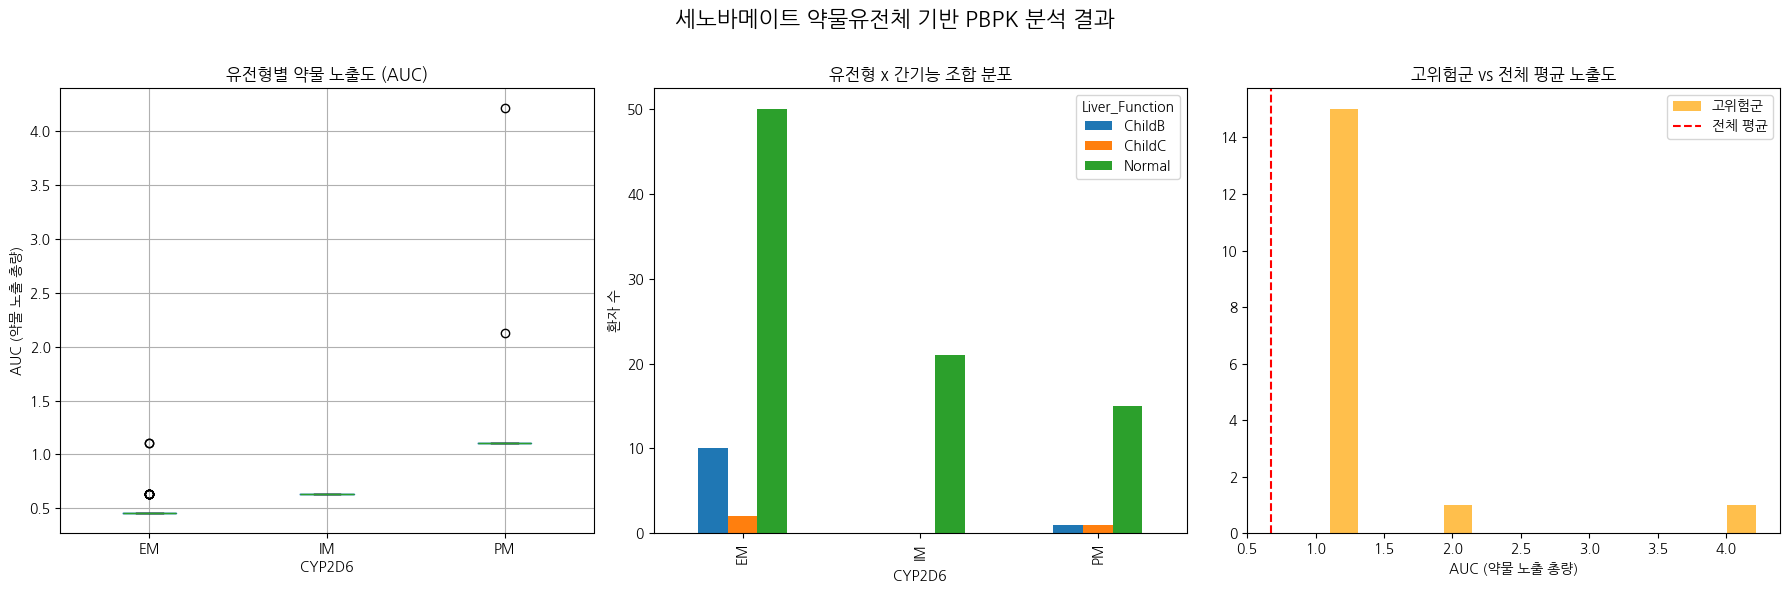

In [11]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 그래프 1: 유전형별 약물 노출도 (Boxplot)
patient_cohort.boxplot(column='AUC_pred', by='CYP2D6', ax=axes[0])
axes[0].set_title('유전형별 약물 노출도 (AUC)')
axes[0].set_ylabel('AUC (약물 노출 총량)')

# 그래프 2: 위험군 조합 확인 (Bar chart)
# ax=axes[1]을 명시하여 두 번째 칸에 정확히 그림
pd.crosstab(patient_cohort['CYP2D6'], patient_cohort['Liver_Function']).plot(kind='bar', ax=axes[1])
axes[1].set_title('유전형 x 간기능 조합 분포')
axes[1].set_ylabel('환자 수')

# 그래프 3: 고위험군 집중 분석 (Histogram)
high_risk = patient_cohort[patient_cohort['HighRisk']]
axes[2].hist(high_risk['AUC_pred'], bins=15, alpha=0.7, color='orange', label='고위험군')
axes[2].axvline(np.mean(AUCs), color='red', linestyle='--', label='전체 평균')
axes[2].set_title('고위험군 vs 전체 평균 노출도')
axes[2].set_xlabel('AUC (약물 노출 총량)')
axes[2].legend()

# 전체 레이아웃 조정 및 저장
plt.suptitle('세노바메이트 약물유전체 기반 PBPK 분석 결과', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85) # 제목 공간 확보
plt.show()
